In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import  MinMaxScaler

'''
    单变量预测模型:
        包括LSTM时序预测层和Linear回归输出层,可以根据自己的情况增加模型结构
'''

training_set = pd.read_csv('data/train.csv')
#training_set = pd.read_csv('shampoo.csv')
training_set = training_set.iloc[:,1:2].values
training_set

array([[12],
       [13],
       [11],
       ...,
       [14],
       [11],
       [10]], dtype=int64)

Epoch: 0, Loss: 0.27244
Epoch: 100, Loss: 0.01917
Epoch: 200, Loss: 0.00368
Epoch: 300, Loss: 0.00316
Epoch: 400, Loss: 0.00295
Epoch: 500, Loss: 0.00286
Epoch: 600, Loss: 0.00282
Epoch: 700, Loss: 0.00280
Epoch: 800, Loss: 0.00278
Epoch: 900, Loss: 0.00277
Epoch: 1000, Loss: 0.00276
Epoch: 1100, Loss: 0.00276
Epoch: 1200, Loss: 0.00275
Epoch: 1300, Loss: 0.00274
Epoch: 1400, Loss: 0.00274
Epoch: 1500, Loss: 0.00273
Epoch: 1600, Loss: 0.00273
Epoch: 1700, Loss: 0.00272
Epoch: 1800, Loss: 0.00272
Epoch: 1900, Loss: 0.00271


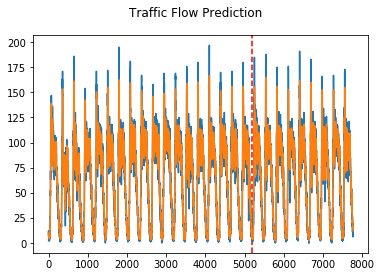

In [10]:
def sliding_windows(seq,n_steps):
    x,y = [],[]
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x),np.array(y)

# 数据归一化
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

# 将数据转换为训练数据格式
n_steps = 12
x,y = sliding_windows(training_data,n_steps)

# 切分数据位训练集和测试集
train_size = int(len(x)*0.67)
test_size = len(x) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(x[0:train_size]))
trainY = Variable(torch.Tensor(y[0:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))

# 构建模型
class LSTM_Predict(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(LSTM_Predict,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.n_steps = n_steps

        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                            num_layers=num_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size,num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),
                                   self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers,x.size(0),
                                   self.hidden_size))

        ula,(h_out,_) = self.lstm(x,(h_0,c_0))
        h_out = h_out.view(-1,self.hidden_size)

        out = self.fc(h_out)
        return out


num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM_Predict(num_classes,input_size,hidden_size,num_layers)

# MSE 误差
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(),lr=learning_rate)


# 轮询输出结果
for epoch in range(num_epochs):
    # 相当于默认调用forward前向传播算法
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # 获得损失函数
    loss = criterion(outputs,trainY)
    # 反向传播求梯度
    loss.backward()
    # 更新所有参数
    optimizer.step()
    if epoch%100==0:
        print("Epoch: %d, Loss: %1.5f" % (epoch,loss.item()))


#Testing for passengers Dataset

lstm.eval()
train_predict = lstm(dataX)


data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Traffic Flow Prediction')
plt.show()

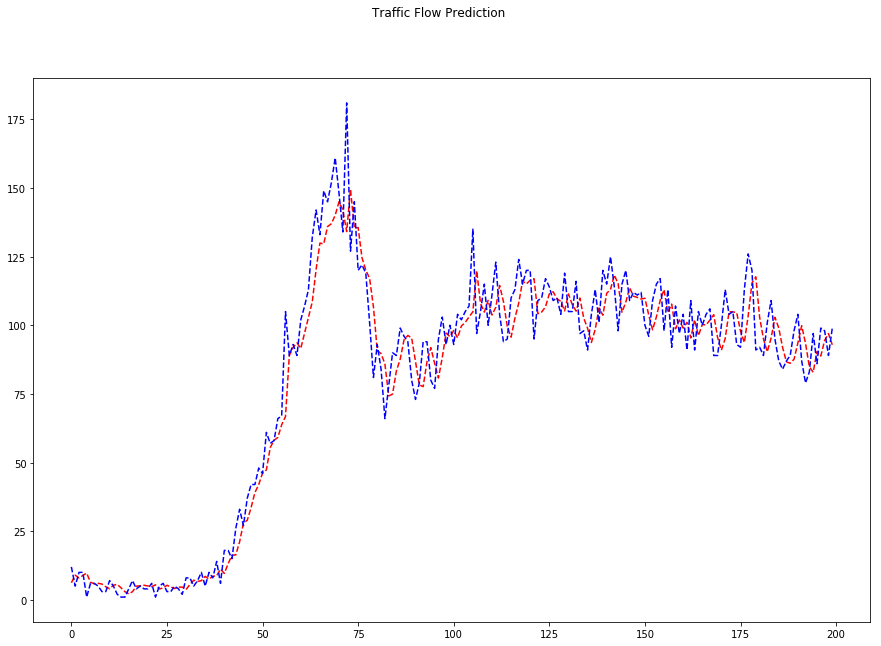

In [29]:
# 加载测试数据集
test_set = pd.read_csv('data/test.csv')
test_set = test_set.iloc[:,1:2].values

def sliding_windows(seq,n_steps):
    x,y = [],[]
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x),np.array(y)

# 数据归一化
sc = MinMaxScaler()

test_data = sc.fit_transform(test_set)

# 将数据转换为训练数据格式
n_steps = 12
test_x,test_y = sliding_windows(test_data,n_steps)

test_x = Variable(torch.Tensor(test_x))
test_y = Variable(torch.Tensor(test_y))

lstm.eval()
test_predict = lstm(test_x)


test_predict = test_predict.data.numpy()
testY_true = test_y.data.numpy()

test_predict = sc.inverse_transform(test_predict)
testY_true = sc.inverse_transform(testY_true)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(15,10))
plt.plot(test_predict[0:200],c='r', linestyle='--')
plt.plot(testY_true[0:200],c='b', linestyle='--')
plt.suptitle('Traffic Flow Prediction')
plt.show()

